# Setup

In [1]:
# load library
import numpy as np
import pandas as pd
import pickle
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from string import punctuation
from gensim.models import KeyedVectors
#eval metrics
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/UChicago/Spring 2022/MACS 37000 Thinking with Deep Learning for Complex Social & Cultural Data Analysis/Misogynistic Memes/MEME-main/')

Mounted at /content/drive


# Preparing Data

In [19]:
#load meme data 
meme = pd.read_csv("/content/drive/MyDrive/UChicago/Spring 2022/MACS 37000 Thinking with Deep Learning for Complex Social & Cultural Data Analysis/Memes/memegendf.csv")
meme = meme[['Filenames','Meme Text']]
meme.columns = ['image','text']
meme['meme'] = 1
meme['path'] = '/content/drive/MyDrive/UChicago/Spring 2022/MACS 37000 Thinking with Deep Learning for Complex Social & Cultural Data Analysis/Memes/memes/'+meme['image']
meme.head()

,image,text,meme,path
0,12285257.jpg,Fret not I stayed at a Holiday Inn Express las...,1,/content/drive/MyDrive/UChicago/Spring 2022/MA...
1,20612245.jpg,"hello airplanes? yeah, this is blimps. Yeah, y...",1,/content/drive/MyDrive/UChicago/Spring 2022/MA...
2,24194267.jpg,one does not simply put toothpaste back in th...,1,/content/drive/MyDrive/UChicago/Spring 2022/MA...
3,10179556.jpg,WE FOUND LOVE IN A HORCRUX place,1,/content/drive/MyDrive/UChicago/Spring 2022/MA...
4,10181785.jpg,Animals not smart enough to believe in me Deny...,1,/content/drive/MyDrive/UChicago/Spring 2022/MA...


In [20]:
#load inspiration quotes data 
quote = pd.read_csv("/content/drive/MyDrive/UChicago/Spring 2022/MACS 37000 Thinking with Deep Learning for Complex Social & Cultural Data Analysis/Memes/inspirational.csv")
quote = quote[['file_name','text']]
quote.columns = ['image','text']
quote['meme'] = 0
quote['path'] = '/content/drive/MyDrive/UChicago/Spring 2022/MACS 37000 Thinking with Deep Learning for Complex Social & Cultural Data Analysis/Memes/inspirational/'+quote['image']
quote.head()

,image,text,meme,path
0,1.jpg,"if you get tired, learn to rest, not to quit.",0,/content/drive/MyDrive/UChicago/Spring 2022/MA...
1,2.jpg,dare to trust yourself,0,/content/drive/MyDrive/UChicago/Spring 2022/MA...
2,3.jpg,christ your key to true power,0,/content/drive/MyDrive/UChicago/Spring 2022/MA...
3,4.jpg,know that dream cometrue,0,/content/drive/MyDrive/UChicago/Spring 2022/MA...
4,5.jpg,does your mind focus on fun,0,/content/drive/MyDrive/UChicago/Spring 2022/MA...


In [21]:
#combine dataset
memeq = pd.concat([meme,quote])
memeq.head()

,image,text,meme,path
0,12285257.jpg,Fret not I stayed at a Holiday Inn Express las...,1,/content/drive/MyDrive/UChicago/Spring 2022/MA...
1,20612245.jpg,"hello airplanes? yeah, this is blimps. Yeah, y...",1,/content/drive/MyDrive/UChicago/Spring 2022/MA...
2,24194267.jpg,one does not simply put toothpaste back in th...,1,/content/drive/MyDrive/UChicago/Spring 2022/MA...
3,10179556.jpg,WE FOUND LOVE IN A HORCRUX place,1,/content/drive/MyDrive/UChicago/Spring 2022/MA...
4,10181785.jpg,Animals not smart enough to believe in me Deny...,1,/content/drive/MyDrive/UChicago/Spring 2022/MA...


In [23]:
#Splitting the data into training, testing sets
from sklearn.model_selection import train_test_split
train, test = train_test_split(memeq, test_size=0.2)

# Image to Vectors

In [24]:
import cv2

def resize_img(path):
  try:
    img = cv2.imread(path)
    img = cv2.resize(img, (75, 115))
    img = img.astype(np.float32)/255
    return img
  except Exception as e:
    print(str(e))
    return None

In [76]:
train_imgs = []
i = 0
for index, row in train.iterrows():
  if i%100 == 0:
    print("Processing i:", i, str(row['path']))
  img = resize_img(str(row['path']))
  if img is not None:
    train_imgs.append(img)
  else:
    train = train.drop(index)
    print("Dropping row:", index, "Length:", len(train))
  i += 1

Processing i: 0 /content/drive/MyDrive/UChicago/Spring 2022/MACS 37000 Thinking with Deep Learning for Complex Social & Cultural Data Analysis/Memes/memes/12406215.jpg
Processing i: 100 /content/drive/MyDrive/UChicago/Spring 2022/MACS 37000 Thinking with Deep Learning for Complex Social & Cultural Data Analysis/Memes/memes/13238279.jpg
Processing i: 200 /content/drive/MyDrive/UChicago/Spring 2022/MACS 37000 Thinking with Deep Learning for Complex Social & Cultural Data Analysis/Memes/memes/10584189.jpg
Processing i: 300 /content/drive/MyDrive/UChicago/Spring 2022/MACS 37000 Thinking with Deep Learning for Complex Social & Cultural Data Analysis/Memes/memes/10417909.jpg
Processing i: 400 /content/drive/MyDrive/UChicago/Spring 2022/MACS 37000 Thinking with Deep Learning for Complex Social & Cultural Data Analysis/Memes/inspirational/837.jpg
Processing i: 500 /content/drive/MyDrive/UChicago/Spring 2022/MACS 37000 Thinking with Deep Learning for Complex Social & Cultural Data Analysis/Meme

In [80]:
test_imgs = []
i = 0
for index, row in test.iterrows():
  if i%100 == 0:
    print("Processing i:", i, str(row['path']))
  img = resize_img(str(row['path']))
  if img is not None:
    test_imgs.append(img)
  else:
    test = test.drop(index)
    print("Dropping row:", index, "Length:", len(test))
  i += 1

Processing i: 0 /content/drive/MyDrive/UChicago/Spring 2022/MACS 37000 Thinking with Deep Learning for Complex Social & Cultural Data Analysis/Memes/memes/11921159.jpg
Processing i: 100 /content/drive/MyDrive/UChicago/Spring 2022/MACS 37000 Thinking with Deep Learning for Complex Social & Cultural Data Analysis/Memes/memes/13427874.jpg
Processing i: 200 /content/drive/MyDrive/UChicago/Spring 2022/MACS 37000 Thinking with Deep Learning for Complex Social & Cultural Data Analysis/Memes/inspirational/968.jpg
Processing i: 300 /content/drive/MyDrive/UChicago/Spring 2022/MACS 37000 Thinking with Deep Learning for Complex Social & Cultural Data Analysis/Memes/memes/12950995.jpg
Processing i: 400 /content/drive/MyDrive/UChicago/Spring 2022/MACS 37000 Thinking with Deep Learning for Complex Social & Cultural Data Analysis/Memes/inspirational/704.jpg


In [81]:
train_np_imgs = np.array(train_imgs)
train_np_imgs.shape

(1646, 115, 75, 3)

In [82]:
test_np_imgs = np.array(test_imgs)
test_np_imgs.shape

(427, 115, 75, 3)

# Text to Vectors

In [60]:
#text cleaning
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
  text = text.translate(str.maketrans('', '', punctuation))
  text = text.lower().strip()
  text = ' '.join([i if i not in stop and i.isalpha() else '' for i in text.lower().split()])
  text = ' '.join([lemmatizer.lemmatize(w) for w in word_tokenize(text)])
  text = re.sub(r"\s{2,}", " ", text)
  return text

train['text'] = train['text'].astype(str)
train['text'] = train['text'].apply(lambda text: clean_text(text))

test['text'] = test['text'].astype(str)
test['text'] = test['text'].apply(lambda text: clean_text(text))



In [32]:
#keras 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Embedding, LSTM, Dropout, Dense, Input, Bidirectional, Flatten, Conv2D, MaxPooling2D, concatenate, Conv1D, MaxPooling1D
import keras.backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

In [61]:
#Fitting the Keras Tokenizer on the entire dataset
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = meme['text'].map(len).max()
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(meme['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print('Max len:', MAX_SEQUENCE_LENGTH)

Found 3881 unique tokens.
Max len: 267


In [34]:
# pretrained google news dataset
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [62]:
#This function loads the word2vec model and intializes the embedding matrix. Each word which is present in the embedding is then added as a vector to the embedding matrix.
def get_embedding_matrix(typeToLoad):
  if typeToLoad == "glove":
    EMBEDDING_FILE="/content/glove.twitter.27B.100d.txt"
    embed_size = 100
  elif typeToLoad == "word2vec":
    #word2vecDict = KeyedVectors.load_word2vec_format("/content/GoogleNews-vectors-negative300.bin", binary=True)
    word2vecDict = wv
    embed_size = 300
  elif typeToLoad == "fasttext":
    EMBEDDING_FILE="/content/wiki-news-300d-1M.vec"
    embed_size = 300

  if typeToLoad == "glove" or typeToLoad == "fasttext":
    embeddings_index = dict()
    f = open(EMBEDDING_FILE)
    for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
    f.close()
    print("Loaded " + str(len(embeddings_index)) + " word vectors.")
  else:
    embeddings_index = dict()
    for word in word2vecDict.wv.vocab:
      embeddings_index[word] = word2vecDict.word_vec(word)
    print("Loaded " + str(len(embeddings_index)) + " word vectors.")
        
  embedding_matrix = 1 * np.random.randn(len(word_index)+1, embed_size)

  embeddedCount = 0
  for word, i in word_index.items():
    i-=1
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
      embedding_matrix[i] = embedding_vector
      embeddedCount+=1
  print("total embedded:", embeddedCount, "common words")
        
  del(embeddings_index)
        
  return embedding_matrix

In [63]:
word2vec_embedding_matrix = get_embedding_matrix("word2vec")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Loaded 3000000 word vectors.
total embedded: 3036 common words


In [83]:
X_text_train = tokenizer.texts_to_sequences(train['text'].values)
X_text_train = pad_sequences(X_text_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train tensor:', X_text_train.shape)

Shape of train tensor: (1646, 267)


In [84]:
X_text_test = tokenizer.texts_to_sequences(test['text'].values)
X_text_test = pad_sequences(X_text_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train tensor:', X_text_test.shape)

Shape of train tensor: (427, 267)


In [85]:
X_img_train = train_np_imgs
X_img_train.shape

X_img_test = test_np_imgs
X_img_test.shape


(427, 115, 75, 3)

In [86]:
train_labels = train['meme']
train_labels.shape

test_labels = test['meme']
test_labels.shape

(427,)

In [87]:
X_img_train.shape

(1646, 115, 75, 3)

In [88]:
X_text_train.shape

(1646, 267)

In [89]:
train_labels.shape

(1646,)

# Multimodel Deep Learning

In [90]:
#The model architecture consists of an LSTM and a CNN. The LSTM takes the input as a padded sequence of the overview of a movie. The CNN takes a movie poster as the input. Each model has a fully connected layer whose output is concatenated and fed forward to a final fully connected layer with 18 output units. The output layer has a sigmoid activation function.
#Binary crossentropy was the chosen loss function and the Adam optimizer was used.
def compile_model(embedding_matrix):
  lstm_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
  x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], mask_zero=True, input_length=MAX_SEQUENCE_LENGTH, trainable=False)(lstm_input)
  x = Dropout(0.3)(x)
  x = LSTM(64, return_sequences = True)(x)
  x = Dropout(0.3)(x)
  x = LSTM(64)(x)
  x = Dropout(0.3)(x)
  lstm_out = Dense(32, activation = 'relu')(x)

  print(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3])
  cnn_input = Input(shape=(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3]))
  y = Conv2D(32, (3, 3), activation='relu', input_shape=(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3]))(cnn_input)
  y = MaxPooling2D(2, 2)(y)
  y = Conv2D(64, (3, 3), activation='relu')(y)
  y = MaxPooling2D(2, 2)(y)
  y = Conv2D(128, (3, 3), activation='relu')(y)
  y = MaxPooling2D(2, 2)(y)
  y = Conv2D(128, (3, 3), activation='relu')(y)
  y = MaxPooling2D(2, 2)(y)
  y = Flatten()(y)
  y = Dropout(0.3)(y)
  cnn_out = Dense(512, activation='relu')(y)

  concat_inp = concatenate([cnn_out, lstm_out])
  z = Dense(256, activation='relu')(concat_inp)
  z = Dropout(0.3)(z)
  z = Dense(128, activation='relu')(z)
  z = Dropout(0.3)(z)
  output = Dense(1, activation='sigmoid')(z)

  model = Model(inputs=[cnn_input, lstm_input], outputs=[output])
  adam = Adam(lr=0.001, decay=1e-5)
  
  model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
  return model

In [91]:
word2vec_model = compile_model(word2vec_embedding_matrix)
word2vec_model.summary()

115 75 3
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 115, 75, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 113, 73, 32)  896         ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 56, 36, 32)  0           ['conv2d_4[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 54, 34, 64)   18496       ['max_pooling2d_4[

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [43]:
es = EarlyStopping(patience=5)
csv_logger = CSVLogger('model_history_log_model_lstm.csv', append=True)
check_point = ModelCheckpoint(filepath='best_lstm_model_todate', save_best_only=True, save_weights_only=True)

In [44]:
train_labels = np.asarray(train_labels).astype('float32').reshape((-1,1))
train_labels.shape

test_labels = np.asarray(test_labels).astype('float32').reshape((-1,1))
test_labels.shape

(443, 1)

In [92]:
word2vec_multi_modal_model = word2vec_model.fit([X_img_train, X_text_train], train_labels, batch_size=100, epochs=20,
                            validation_data=([X_img_test, X_text_test], test_labels), callbacks = [es, csv_logger, check_point])

Epoch 1/20
17/17 [==============================] - 58s 3s/step - loss: 0.4271 - accuracy: 0.7776 - val_loss: 0.1426 - val_accuracy: 0.9532
Epoch 2/20
17/17 [==============================] - 44s 3s/step - loss: 0.1336 - accuracy: 0.9550 - val_loss: 0.0715 - val_accuracy: 0.9719
Epoch 3/20
17/17 [==============================] - 44s 3s/step - loss: 0.0710 - accuracy: 0.9793 - val_loss: 0.0264 - val_accuracy: 0.9906
Epoch 4/20
17/17 [==============================] - 47s 3s/step - loss: 0.0442 - accuracy: 0.9860 - val_loss: 0.0132 - val_accuracy: 0.9977
Epoch 5/20
17/17 [==============================] - 44s 3s/step - loss: 0.0334 - accuracy: 0.9927 - val_loss: 0.0186 - val_accuracy: 0.9930
Epoch 6/20
17/17 [==============================] - 44s 3s/step - loss: 0.0295 - accuracy: 0.9927 - val_loss: 0.0167 - val_accuracy: 0.9953
Epoch 7/20
17/17 [==============================] - 44s 3s/step - loss: 0.0103 - accuracy: 0.9982 - val_loss: 0.0070 - val_accuracy: 0.9977
Epoch 8/20
17/17 [==

In [93]:
def plot_loss(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend(['training loss', 'validation loss'], loc='upper right')
  plt.show()

def plot_acc(history):
  plt.title('Accuracy')
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
  plt.show()

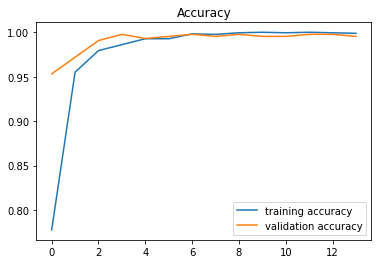

In [94]:
plot_acc(word2vec_multi_modal_model)

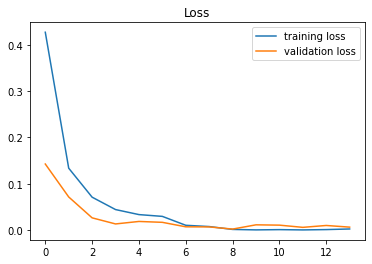

In [95]:
plot_loss(word2vec_multi_modal_model)

# Multimodel Deep Learning: Shallow

In [117]:
#The model architecture consists of an LSTM and a CNN. The LSTM takes the input as a padded sequence of the overview of a movie. The CNN takes a movie poster as the input. Each model has a fully connected layer whose output is concatenated and fed forward to a final fully connected layer with 18 output units. The output layer has a sigmoid activation function.
#Binary crossentropy was the chosen loss function and the Adam optimizer was used.
def shallow_compile_model(embedding_matrix):
  lstm_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
  x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], mask_zero=True, input_length=MAX_SEQUENCE_LENGTH, trainable=False)(lstm_input)
  x = Dropout(0.3)(x)
  x = LSTM(64, return_sequences = True)(x)
  x = Dropout(0.3)(x)
  x = LSTM(64)(x)
  x = Dropout(0.3)(x)
  lstm_out = Dense(32, activation = 'relu')(x)

  print(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3])
  cnn_input = Input(shape=(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3]))
  y = Conv2D(32, (3, 3), activation='relu', input_shape=(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3]))(cnn_input)
  y = MaxPooling2D(2, 2)(y)
  #y = Conv2D(64, (3, 3), activation='relu')(y)
  #y = MaxPooling2D(2, 2)(y)
  #y = Conv2D(128, (3, 3), activation='relu')(y)
  #y = MaxPooling2D(2, 2)(y)
  #y = Conv2D(128, (3, 3), activation='relu')(y)
  #y = MaxPooling2D(2, 2)(y)
  y = Flatten()(y)
  y = Dropout(0.3)(y)
  cnn_out = Dense(512, activation='relu')(y)

  concat_inp = concatenate([cnn_out, lstm_out])
  z = Dense(256, activation='relu')(concat_inp)
  z = Dropout(0.3)(z)
  z = Dense(128, activation='relu')(z)
  z = Dropout(0.3)(z)
  output = Dense(1, activation='sigmoid')(z)

  model = Model(inputs=[cnn_input, lstm_input], outputs=[output])
  adam = Adam(lr=0.001, decay=1e-5)
  
  model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
  return model

In [118]:
word2vec_model = shallow_compile_model(word2vec_embedding_matrix)
word2vec_model.summary()

115 75 3
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 267)]        0           []                               
                                                                                                  
 embedding_13 (Embedding)       (None, 267, 300)     1164600     ['input_27[0][0]']               
                                                                                                  
 input_28 (InputLayer)          [(None, 115, 75, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 dropout_56 (Dropout)           (None, 267, 300)     0           ['embedding_13[0][

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [119]:
word2vec_multi_modal_model = word2vec_model.fit([X_img_train, X_text_train], train_labels, batch_size=100, epochs=20,
                            validation_data=([X_img_test, X_text_test], test_labels), callbacks = [es, csv_logger, check_point])

Epoch 1/20
17/17 [==============================] - 48s 2s/step - loss: 1.0820 - accuracy: 0.7272 - val_loss: 0.0695 - val_accuracy: 0.9859
Epoch 2/20
17/17 [==============================] - 34s 2s/step - loss: 0.1017 - accuracy: 0.9684 - val_loss: 0.0267 - val_accuracy: 0.9906
Epoch 3/20
17/17 [==============================] - 35s 2s/step - loss: 0.0380 - accuracy: 0.9897 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 4/20
17/17 [==============================] - 33s 2s/step - loss: 0.0105 - accuracy: 0.9976 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 5/20
17/17 [==============================] - 37s 2s/step - loss: 0.0049 - accuracy: 0.9988 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 6/20
17/17 [==============================] - 39s 2s/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0246 - val_accuracy: 0.9930
Epoch 7/20
17/17 [==============================] - 34s 2s/step - loss: 0.0077 - accuracy: 0.9957 - val_loss: 0.0153 - val_accuracy: 0.9953
Epoch 8/20
17/17 [==

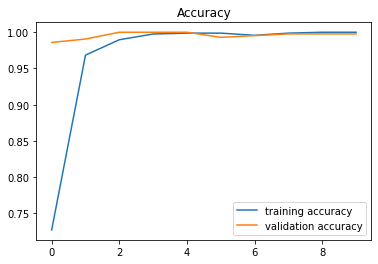

In [120]:
plot_acc(word2vec_multi_modal_model)

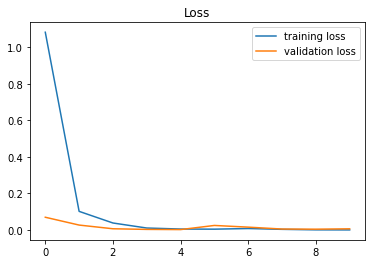

In [121]:
plot_loss(word2vec_multi_modal_model)